In [1]:
import numpy as np
import xarray as xr 

import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm
import glidertools as gt

from cmocean import cm as cmo

import gsw

In [6]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659_20201010/O2_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660_20201010/O2_660.nc'

ds_O2_659 = xr.load_dataset(data_659)
ds_O2_660 = xr.load_dataset(data_660)

In [7]:
data_659 = data_dir+'/data/interim/gliders/sg659_20201010/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660_20201010/CTD_660.nc'

ds_CTD_659 = xr.load_dataset(data_659)
ds_CTD_660 = xr.load_dataset(data_660)

In [8]:
# easier to work with a days variable that is a float rather than datenum
days = ds_CTD_659.time - np.datetime64('2019-01-01')
ds_CTD_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_O2_659.time - np.datetime64('2019-01-01')
ds_O2_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_CTD_660.time - np.datetime64('2019-01-01')
ds_CTD_660['days'] = (days / np.timedelta64(1, 'D'))

days = ds_O2_660.time - np.datetime64('2019-01-01')
ds_O2_660['days'] = (days / np.timedelta64(1, 'D'))


In [9]:
# Interpolate and grid glider data on pressure-time axis
# There are many ways this can be done. We choose a simple linear interpolation 
# in time and pressure.
# We could alternatively interpolate in density-time, pressure-distance, dive-pressure etc.
# This a place where a lot of more work into GP and 
# learning the most optimal interpolation (in sense of MLE) might work. 

# Note this is different from what glidertools does, which does a simple binning. 

# In future version we could also sort based on density field before applying 
# a bit of smoothing.

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,501)
    time_grid = np.arange(119, 207, 1/24)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

def interp_pres_dist(ds_glid, var): 
    pres_ug = ds_glid.pressure
    dist_ug = ds_glid.distance
    
    # convert to points values
    points = np.stack([dist_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,501)
    dist_grid = np.arange(0, dist_ug.max().values, 1)
    grid_p, grid_d = np.meshgrid(pres_grid, dist_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_d, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "distance"],
                          coords={"pressure":pres_grid,
                                    "distance":dist_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider_time_pres(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

def convert_glider_dist_pres(ds_glid, vars_convert= ['temperature','salinity','potdens','spice']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_dist(ds_glid, v)
    
    return ds_grid

In [10]:
# method to go from O2 point -> CTD point
# Then can apply distance interpolation to O2 as well 
ds_O2_on_CTD_659 = xr.DataArray(np.interp(ds_CTD_659.days, ds_O2_659.days, ds_O2_659.oxygen),
                               dims = ds_CTD_659.dims, 
                               coords = ds_CTD_659.coords).rename('oxygen')
ds_O2_on_CTD_660 = xr.DataArray(np.interp(ds_CTD_660.days, ds_O2_660.days, ds_O2_660.oxygen),
                               dims = ds_CTD_660.dims, 
                               coords = ds_CTD_660.coords).rename('oxygen')


In [11]:
ds_O2_on_CTD_660

<xarray.DataArray 'oxygen' (ctd_data_point: 1354132)>
array([321.09963323, 321.09963323, 321.09963323, ..., 323.99670756,
       323.99670756, 323.99670756])
Dimensions without coordinates: ctd_data_point

In [12]:
T_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    ds_CTD_659.temperature, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [22]:
S_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    ds_CTD_659.salinity, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [49]:
potdens_659 = gt.physics.potential_density(ds_CTD_659.salinity, 
                                           ds_CTD_659.temperature, 
                                           ds_CTD_659.pressure, 
                                           ds_CTD_659.latitude, 
                                           ds_CTD_659.longitude)

In [50]:
pdens_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    potdens_659, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [23]:
O2_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    ds_O2_on_CTD_659, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [15]:
lon_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    ds_CTD_659.longitude, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [16]:
lat_659 = gt.grid_data(ds_CTD_659.dives, ds_CTD_659.pressure, 
                    ds_CTD_659.latitude, bins = np.arange(10,950,10) )

Mean bin size = 10.00
Mean depth binned (50 m) vertical sampling frequency = 0.63


In [19]:
SA_659 = gsw.SA_from_SP(S_659, S_659.pressure, lon_659, lat_659)
CT_659 = gsw.CT_from_t(SA_659, T_659,  T_659.pressure)

In [21]:
O2sol_659 = gsw.O2sol(SA_659, CT_659, CT_659.pressure, lon_659, lat_659)

In [24]:
# AOU = O2_sat - O2 (positive means oxygen has been lost relative to satu value)
AOU_659 = O2sol_659 - O2_659

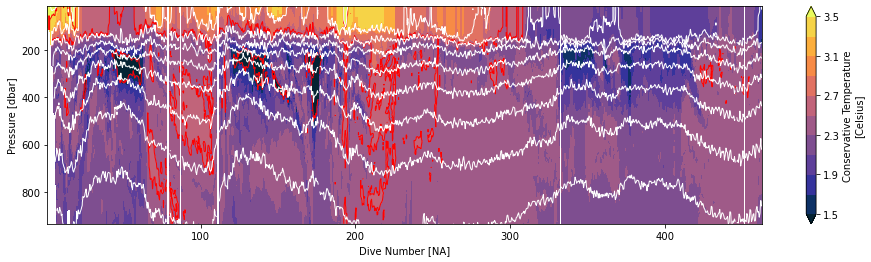

In [51]:
plt.figure(figsize=(16,4))
T_659.plot.contourf(levels = 11, vmin=1.5, vmax=3.5, cmap =cmo.thermal)
T_659.plot.contour(levels = [1.5, 2.5, 3.5], vmin=1, vmax=3.5, linewidths=1, colors='r')
pdens_659.plot.contour(levels = np.linspace(1026.8 , 1027.8, 11),  linewidths=1, colors='w')
plt.gca().invert_yaxis()

(500.0, 0.0)

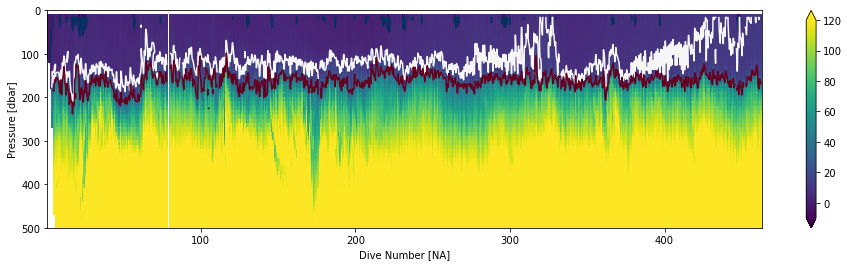

In [67]:
plt.figure(figsize=(16,4))
AOU_659.plot(vmin=-10, vmax=120)
AOU_659.plot.contour(levels=[0, 10, 30])
#T_659.plot.contour(levels = [1.5, 2.5, 3.5], vmin=1, vmax=3.5, linewidths=0.5)
plt.gca().invert_yaxis()
plt.ylim([500,0])

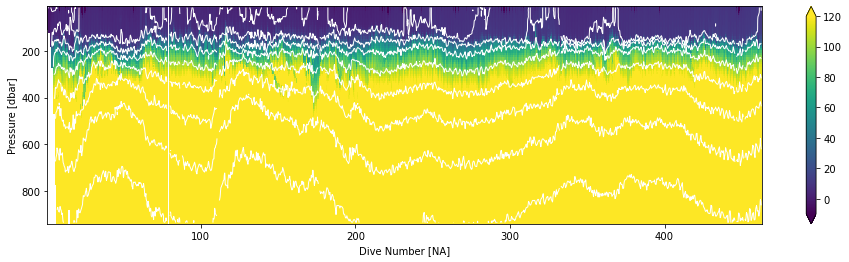

In [52]:
plt.figure(figsize=(16,4))
AOU_659.plot(vmin=-10, vmax=120)
pdens_659.plot.contour(levels = np.linspace(1026.8 , 1027.8, 11),  linewidths=1, colors='w')
plt.gca().invert_yaxis()

(500.0, 0.0)

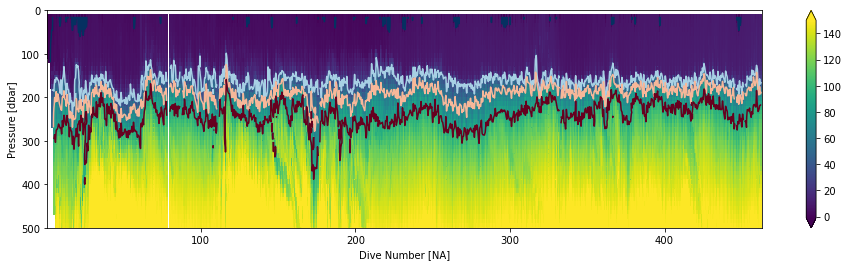

In [60]:
plt.figure(figsize=(16,4))
AOU_659.plot(vmin=-1, vmax=150)
#T_659.plot.contour(levels = [1.5, 2.5, 3.5], vmin=1, vmax=3.5, linewidths=0.5)
#pdens_659.plot.contour(levels = np.linspace(1026.8 , 1027.8, 11),  linewidths=1, colors='w')
AOU_659.plot.contour(levels = [0, 30, 60, 90])


plt.gca().invert_yaxis()
plt.ylim([500, 0])

(500.0, 0.0)

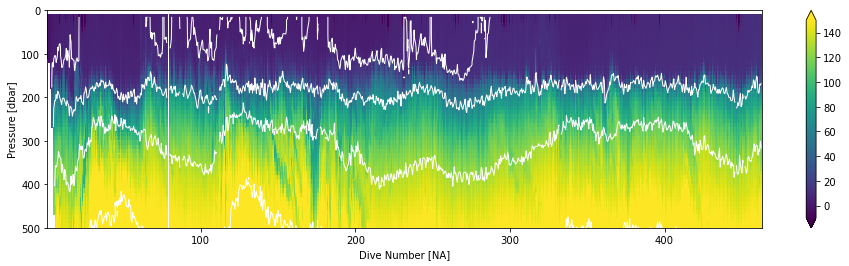

In [58]:
plt.figure(figsize=(16,4))
AOU_659.plot(vmin=-10, vmax=150)
#T_659.plot.contour(levels = [1.5, 2.5, 3.5], vmin=1, vmax=3.5, linewidths=0.5)
pdens_659.plot.contour(levels = np.linspace(1026.8 , 1027.8, 6),  linewidths=1, colors='w')
#AOU_659.plot.contour(levels = [30, 60, 90], colors='r')


plt.gca().invert_yaxis()
plt.ylim([500, 0])

In [ ]:
ds_659_Tgrid = convert_glider_time_pres(ds_CTD_659, vars_convert= ['temperature','salinity','potdens', 'oxygen', 'Chl'])
ds_660_Tgrid = convert_glider_time_pres(ds_CTD_660, vars_convert= ['temperature','salinity','potdens', 'oxygen', 'Chl'])
